<a href="https://colab.research.google.com/github/charlottejin95/recommendation-system/blob/main/Moive_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Moive Recommendation System using ALS in Spark**
In this notebook, I use an **Alternating Least Squares (ALS) algorithm with Spark APIs** to predict movie ratings for different users, providing movie suggestions based on user historical watches.\
\
**Data set** used in the analysis: [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

# Environment Setup

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
!ls

sample_data  spark-3.5.5-bin-hadoop3  spark-3.5.5-bin-hadoop3.tgz


In [6]:
spark.version

'3.5.5'

In [7]:
from pyspark.sql.functions import col,explode,split
from pyspark.sql.types import IntegerType, FloatType

# Data ETL and Data Exploration

**Data used**: [MovieLens dataset](https://grouplens.org/datasets/movielens/latest/)\
**Data set summary**: \
This dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

This data set includes the following files: `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.



In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
movies_df = spark.read.load("drive/MyDrive/Colab Notebooks/LO-Projects/ML Project/Movie Recommendation System/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/MyDrive/Colab Notebooks/LO-Projects/ML Project/Movie Recommendation System/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/MyDrive/Colab Notebooks/LO-Projects/ML Project/Movie Recommendation System/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/MyDrive/Colab Notebooks/LO-Projects/ML Project/Movie Recommendation System/tags.csv", format='csv', header = True)

**`movies.csv`**: \
Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format: *movieId*, *title*, *genres*. Movie titles are entered manually or imported from <https://www.themoviedb.org/>, including the year of release in parentheses. Genres are a pipe-separated list.

In [11]:
movies_df.show(5,truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



**`ratings.csv`**:\
All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format: *userId*, *movieId*, *rating*, *timestamp*. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [12]:
ratings_df.show(5,truncate=False)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1     |6      |4.0   |964982224|
|1     |47     |5.0   |964983815|
|1     |50     |5.0   |964982931|
+------+-------+------+---------+
only showing top 5 rows



**`links.csv`**:
Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format: *movieId*, *imdbId*, *tmdbId*.

- movieId is an identifier for movies used by <https://movielens.org>.\
 E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

- imdbId is an identifier for movies used by <http://www.imdb.com>.\
 E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

- tmdbId is an identifier for movies used by <https://www.themoviedb.org>.\
 E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.

Use of the resources listed above is subject to the terms of each provider.

In [13]:
links_df.show(5,truncate=False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
+-------+-------+------+
only showing top 5 rows



**`tags.csv`**:\
All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format: *userId*, *movieId*, *tag*, *timestamp*. Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user. Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [14]:
tags_df.show(5,truncate=False)

+------+-------+---------------+----------+
|userId|movieId|tag            |timestamp |
+------+-------+---------------+----------+
|2     |60756  |funny          |1445714994|
|2     |60756  |Highly quotable|1445714996|
|2     |60756  |will ferrell   |1445714992|
|2     |89774  |Boxing story   |1445715207|
|2     |89774  |MMA            |1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [15]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [16]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


# Part 1: Using Spark SQL for OLAP Taskes

In [17]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/content/spark-3.5.5-bin-hadoop3/python/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Analysis on: the number of users

In [18]:
num_user=spark.sql("select count(distinct userid) as num_of_users from ratings")
#ratings_df.select('userid').distinct().count()
print('The total number of users in the data set is: ')
num_user.show(truncate=False)

The total number of users in the data set is: 
+------------+
|num_of_users|
+------------+
|610         |
+------------+



### Analysis on: the number of movies

In [19]:
num_movie=spark.sql("select count(distinct movieid) as num_of_movies from movies")
#movies_df.select('movieid').distinct().count()
print('The total number of movies in the data set is: ')
num_movie.show(truncate=False)

The total number of movies in the data set is: 
+-------------+
|num_of_movies|
+-------------+
|9742         |
+-------------+



### Analysis on: the number of movies rated by users

In [20]:
movie_rated=spark.sql("select t1.*,t2.userid,t2.rating,t2.timestamp as rating_timestamp \
                      from movies t1 left join ratings t2 on t1.movieid=t2.movieid")

num_movie_rated=movie_rated.filter(col("userid").isNotNull()).select('movieid').distinct().count()
print('Among all movies, there are {} movies that are rated by users.'.format(num_movie_rated))

num_movie_not_rated=movie_rated.filter(col('userid').isNull()).select('movieid').distinct().count()
print('There are {} movies that are not rated by users.'.format(num_movie_not_rated))
print("Here's the list of movies not rated: ")
movie_rated.filter(col('userid').isNull()).select('movieid','title','genres').show(truncate=False)

Among all movies, there are 9724 movies that are rated by users.
There are 18 movies that are not rated by users.
Here's the list of movies not rated: 
+-------+--------------------------------------------+------------------------+
|movieid|title                                       |genres                  |
+-------+--------------------------------------------+------------------------+
|1076   |Innocents, The (1961)                       |Drama|Horror|Thriller   |
|2939   |Niagara (1953)                              |Drama|Thriller          |
|3338   |For All Mankind (1989)                      |Documentary             |
|3456   |Color of Paradise, The (Rang-e khoda) (1999)|Drama                   |
|4194   |I Know Where I'm Going! (1945)              |Drama|Romance|War       |
|5721   |Chosen, The (1981)                          |Drama                   |
|6668   |Road Home, The (Wo de fu qin mu qin) (1999) |Drama|Romance           |
|6849   |Scrooge (1970)                         

### Analysis on: the list of movie genres

In [21]:
all_genres=movies_df.select('genres')\
                    .withColumn('each_genre',explode(split(col('genres'),'[|]')))\
                    .select('each_genre')\
                    .distinct()\
                    .orderBy('each_genre',ascending=True)
print('The list of all genres is: ')
all_genres.show(truncate=False)

The list of all genres is: 
+------------------+
|each_genre        |
+------------------+
|(no genres listed)|
|Action            |
|Adventure         |
|Animation         |
|Children          |
|Comedy            |
|Crime             |
|Documentary       |
|Drama             |
|Fantasy           |
|Film-Noir         |
|Horror            |
|IMAX              |
|Musical           |
|Mystery           |
|Romance           |
|Sci-Fi            |
|Thriller          |
|War               |
|Western           |
+------------------+



### Analysis on: the number of movie for each genre

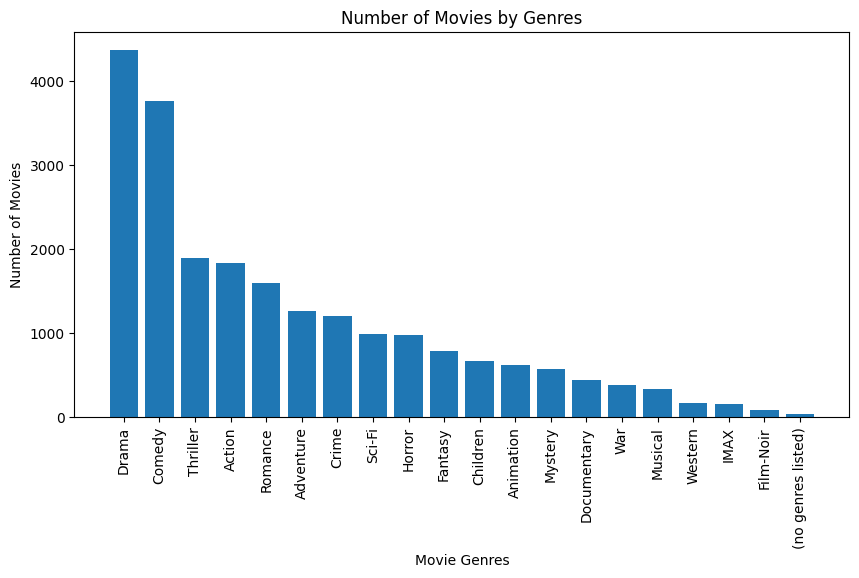

In [21]:
movie_count_by_category=movies_df.withColumn('each_genre',explode(split(col('genres'),'[|]')))\
                                 .select('movieid','each_genre')\
                                 .groupBy('each_genre')\
                                 .count()\
                                 .withColumnRenamed('count','num_of_movie')\
                                 .orderBy('num_of_movie',ascending=False)
v1=movie_count_by_category.toPandas()
fig=plt.figure(figsize=(10,5))
plt.bar(v1['each_genre'],v1['num_of_movie'])
plt.xticks(rotation=90)
plt.xlabel('Movie Genres')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genres')
fig.show()

In [27]:
genre_movie_list=spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movies \
                            From(Select explode(split(genres,'[|]')) as genres, title From movies) \
                            Group By 1")
genre_movie_list.show(2) #truncate=False

+-------+--------------------+
| genres|      list_of_movies|
+-------+--------------------+
|  Crime|Stealing Rembrand...|
|Romance|Vampire in Brookl...|
+-------+--------------------+
only showing top 2 rows



# Part2: Train Model using Spark ALS based Matrix Factorization
Use matrix factorization ML model using Spark ALS optimization method to predict movie ratings for each user.

In [23]:
#Aim: Convert data to the form of (user, item, rating) tuples.
movie_ratings=ratings_df.drop('timestamp')

# Data type convert
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

movie_ratings.show(3)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
+------+-------+------+
only showing top 3 rows



### ALS--Matrix Factorization Model Selection and Evaluation

With matrix factorization model, use a grid search to find the optimal hyperparameters for `maxIter`, `rank`, and `regParam`.

In [24]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [25]:
#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

#Create ALS model
als = ALS(maxIter=5, #max number of iterations/alternates between solving user matrix/item matrix
          rank=10, #rank of the factorization matrix，矩阵的秩
          regParam=0.01, #regularization parameter, prevent overfitting
          userCol="userId", #column name for user ids
          itemCol="movieId", #column name for item ids
          ratingCol="rating", #column name for ratings
          coldStartStrategy="drop"
          #strategy for dealing with unknown or new users/items at prediction time.
          #handling user/item ids the model has not seen in the training data
          )

#Tune model using ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(als.regParam, [0.05, 0.1, 0.3, 0.5])
             .addGrid(als.rank, [5, 10, 15])
             .addGrid(als.maxIter, [1, 5, 10]) #Note: 1 is too smaller; 5 to 10 has not much difference
             .build())

# Define evaluator as RMSE(Root mean square error )
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

# Build Cross validation
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)


In [28]:
#Fit ALS model to training data
cvModel = cv.fit(training)

#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

In [29]:
results = []
for params, metric in zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics):
    results.append({
        'maxIter': params[als.maxIter],
        'rank': params[als.rank],
        'regParam': params[als.regParam],
        'rmse': metric
    })
results_df=pd.DataFrame(results)

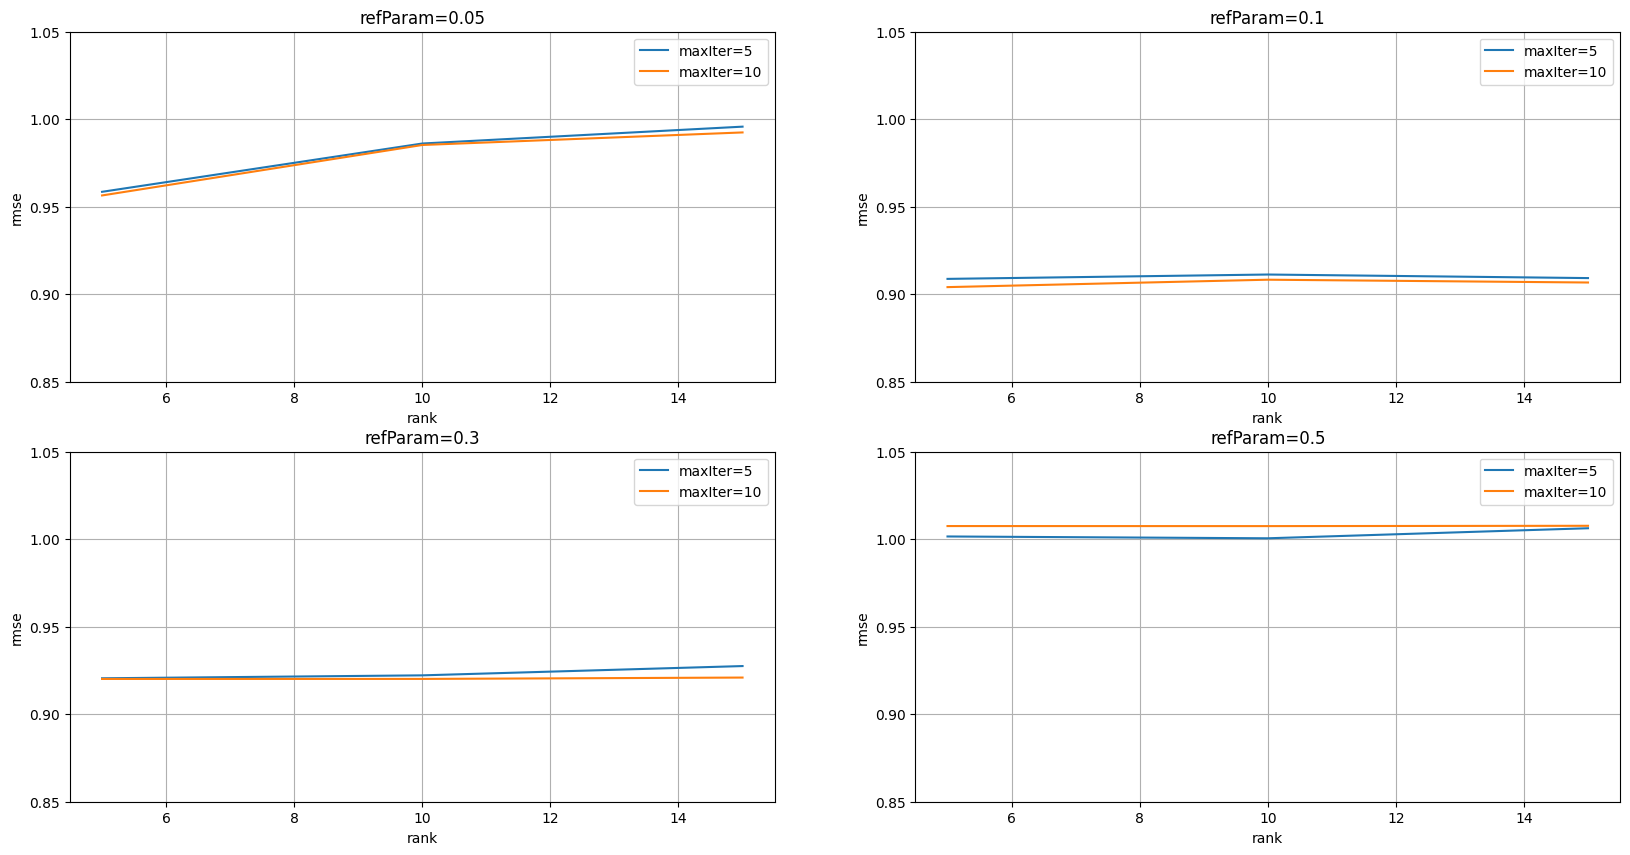

In [30]:
fig=plt.figure(figsize=(20,10))
regParam_list=[0.05, 0.1, 0.3, 0.5]
max_iter_list=[5, 10]#1,

for i in range(1,5):
  a=fig.add_subplot(2,2,i)
  df_rp=results_df[results_df['regParam']==regParam_list[i-1]]
  for value in max_iter_list:
    plt.plot(df_rp[df_rp['maxIter']==value]['rank'],df_rp[df_rp['maxIter']==value]['rmse'],label='maxIter='+str(value))

  plt.legend()#loc='upper center'
  plt.xlabel('rank')
  plt.ylabel('rmse')
  plt.yticks(np.arange(0.85,1.05,0.05))
  plt.grid()
  plt.title('refParam='+str(regParam_list[i-1]))

#plt.title('ALS Model CV Results')


**Comments:**

Based on the above grid search result, the higher the number of iterations, the better the model result is. But looking at the result, **there's no huge difference between iteration 5 and 10**, which means that the incremental value is very minimum for increasing maxIter from 5 to 10. As a result, in order to save computation resources, we **use maxIter=5 to continue search for optimal hyperparameter for refParam and rank** because they seems to have a stronger effect on model performance.

In [26]:
#Tune model using ParamGridBuilder
paramGrid_v2 = (ParamGridBuilder()
             .addGrid(als.regParam, np.arange(0.1,0.3,0.05))
             .addGrid(als.rank, [5, 10, 15])#Note: not too much effects
             .addGrid(als.maxIter, [5]) #Note: 1 is too smaller; 5 to 10 has not much difference
             .build())

# Define evaluator as RMSE(Root mean square error )
evaluator= RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

# Build Cross validation
cv_v2 = CrossValidator(estimator=als, estimatorParamMaps=paramGrid_v2, evaluator=evaluator, numFolds=5)


In [27]:
#Fit ALS model to training data
cvModel_v2 = cv_v2.fit(training)

results_v2 = []
for params, metric in zip(cvModel_v2.getEstimatorParamMaps(), cvModel_v2.avgMetrics):
    results_v2.append({
        'maxIter': params[als.maxIter],
        'rank': params[als.rank],
        'regParam': params[als.regParam],
        'rmse': metric
    })
results_df_v2=pd.DataFrame(results_v2)

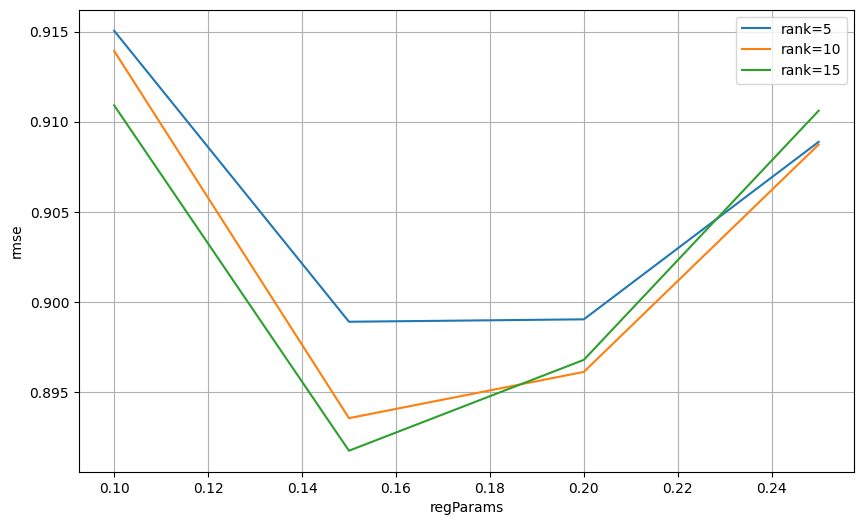

In [28]:
fig=plt.figure(figsize=(10,6))

for value in [5, 10, 15]:
  plt.plot(results_df_v2[results_df_v2['rank']==value]['regParam'],
           results_df_v2[results_df_v2['rank']==value]['rmse'],
           label='rank='+str(value))

plt.legend()#loc='upper center'
plt.xlabel('regParams')
plt.ylabel('rmse')
#plt.yticks(np.arange(0.85,1.05,0.05))
plt.grid()
#plt.title('ALS Model CV Results')

**Comments:**

Based on the above grid search result, **`rank=15`** can generate the best result because it allows the matrix factorization model to better capture more underlying features for both users and movies.\
In addition, **`regParams=0.15`** can generate better results to reduce overfitting problem.\
As a result, we use the following hyper-parameter set as our final model:
```python
{ maxIter=5, rank=15,regParams=0.15 }
```

In [29]:
#Get best model from the tuning process
bestModel_v2=cvModel_v2.bestModel

### Model Performance Testing
Using the test set, make predictions and check the RMSE error.

In [36]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

#Print evaluation metrics and model parameters
print ("**Best Model**")

print('The performance on test set is:')
print ("   RMSE = {:.3f}".format(rmse))
print('The hyper-parameters chosen are:')
print ("   MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())),
print ("   Rank: ", str(bestModel._java_obj.parent().getRank())),
print ("   RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

**Best Model**
The performance on test set is:
   RMSE = 0.881
The hyper-parameters chosen are:
   MaxIter:  10
   Rank:  5
   RegParam:  0.1


In [30]:
#Generate predictions and evaluate using RMSE
predictions_v2=bestModel_v2.transform(test)
rmse_v2 = evaluator.evaluate(predictions_v2)

#Print evaluation metrics and model parameters
print ("**Best Model V2**")

print('The performance on test set is:')
print ("   RMSE = {:.3f}".format(rmse_v2))
print('The hyper-parameters chosen are:')
print ("   MaxIter: ", str(bestModel_v2._java_obj.parent().getMaxIter())),
print ("   Rank: ", str(bestModel_v2._java_obj.parent().getRank())),
print ("   RegParam: ", str(bestModel_v2._java_obj.parent().getRegParam()))

**Best Model V2**
The performance on test set is:
   RMSE = 0.879
The hyper-parameters chosen are:
   MaxIter:  5
   Rank:  15
   RegParam:  0.15000000000000002


In [31]:
#Based on the previous model performance evaluation,
#choose to use the second model as the final one.
bestModel=bestModel_v2

In [32]:
predictions_v2.show(10)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|   1197|   3.0| 3.8217976|
|   148|   4308|   4.0| 3.3085768|
|   148|   4886|   3.0| 3.6290193|
|   148|   4993|   3.0| 3.7049968|
|   148|   7153|   3.0|  3.824168|
|   148|  31658|   4.0| 3.6517057|
|   148|  40815|   4.0| 3.5276034|
|   148|  69844|   4.0| 3.6105676|
|   148|  72998|   4.0| 3.5471852|
|   148|  76093|   3.0| 3.7875032|
+------+-------+------+----------+
only showing top 10 rows



### Model Application & Test Usage Performance

In [43]:
alldata=bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print('The performance on the entire data set is:')
print ("  RMSE = {:.3f}".format(rmse))

print('')
print('Observe that input data set has {} rows; but output data set only has {} rows.'.format(movie_ratings.count(),alldata.count()))
print('This is because ALS can’t predict ratings for users or movies that weren’t in the training data--Cold start problem')


The performance on the entire data set is:
  RMSE = 0.688

Observe that input data set has 100836 rows; but output data set only has 100078 rows.
This is because ALS can’t predict ratings for users or movies that weren’t in the training data--Cold start problem


In [44]:
alldata.createOrReplaceTempView("alldata")
spark.sql("select * from movies \
           join alldata on movies.movieId=alldata.movieId").show(10)

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|   463|   1088|   3.5| 3.3384335|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   137|   1580|   3.5| 3.1827633|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   580|   1580|   4.0| 3.4940007|
|   3175| Galaxy Quest (1999)|Adventure|Comedy|...|   580|   3175|   2.5|  3.366384|
|  44022|Ice Age 2: The Me...|Adventure|Animati...|   580|  44022|   3.5| 3.2300854|
|    471|Hudsucker Proxy, ...|              Comedy|   133|    471|   4.0|  2.826408|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   322|   1580|   3.5| 3.1933763|
|   1591|        Spawn (1997)|Action|Adventure|...|   362|   1591|   4.0| 2.8936012|
|   1645|The Devil's Advoc...|Drama|Mystery|Thr...|   362|   1645

# Part3: Applications

###Recommend moive for user: 280 & 520.
In this example, choose user 280 & 520 to recommend top 10 moives based on their preference

In [182]:
#Generate top 10 recommendations:
userRecs = bestModel.recommendForAllUsers(10)

userRecs_ks=userRecs.toPandas()
movies_ks=movies_df.toPandas()

In [76]:
def movieRecommendation(inputId):
  recs_list=[]
  for recs in userRecs_ks.loc[userRecs_ks['userId']==inputId,'recommendations'].tolist()[0]:
    recs_list.append(str(recs[0]))
  return (movies_ks[movies_ks['movieId'].isin(recs_list)])

In [80]:
print("Recommended movies for user with id '280' are as follows.")
movieRecommendation(280)

Recommended movies for user with id '280' are as follows.


,movieId,title,genres
1707,2295,"Impostors, The (1998)",Comedy
2523,3379,On the Beach (1959),Drama
3320,4495,Crossing Delancey (1988),Comedy|Romance
4251,6201,Lady Jane (1986),Drama|Romance
5236,8580,Into the Woods (1991),Adventure|Comedy|Fantasy|Musical
5429,25906,Mr. Skeffington (1944),Drama|Romance
5906,33649,Saving Face (2004),Comedy|Drama|Romance
7252,74282,Anne of Green Gables: The Sequel (a.k.a. Anne ...,Children|Drama|Romance
7332,77846,12 Angry Men (1997),Crime|Drama
7827,93008,"Very Potter Sequel, A (2010)",Comedy|Musical


In [79]:
print("Recommended movies for user with id '520' are as follows.")
movieRecommendation(520)

Recommended movies for user with id '520' are as follows.


,movieId,title,genres
1707,2295,"Impostors, The (1998)",Comedy
2410,3200,"Last Detail, The (1973)",Comedy|Drama
2523,3379,On the Beach (1959),Drama
3320,4495,Crossing Delancey (1988),Comedy|Romance
3908,5490,The Big Bus (1976),Action|Comedy
4121,5915,Victory (a.k.a. Escape to Victory) (1981),Action|Drama|War
4251,6201,Lady Jane (1986),Drama|Romance
5202,8477,"Jetée, La (1962)",Romance|Sci-Fi
5906,33649,Saving Face (2004),Comedy|Drama|Romance
6999,67618,Strictly Sexual (2008),Comedy|Drama|Romance


### Find similar moives for moive:463 & 471

Find similar moives based on ALS matrix factorization results in the **ItemFactor Matrix**

In [183]:
#Get the item matrix from the model
itemFactors=bestModel.itemFactors.toPandas()

In [186]:
def similarMovies(inputId, matrix='cosine_similarity'):
  try:
    movieFeature=itemFactors.loc[itemFactors.id==inputId,'features'].to_numpy()[0]
  except:
    return 'There is no movie with id ' + str(inputId)

  if matrix=='cosine_similarity':
    similarMovie_list=[]
    for id,feature in itemFactors.to_numpy():
      cs=np.dot(movieFeature,feature)/(np.linalg.norm(movieFeature) * np.linalg.norm(feature))
      similarMovie_list.append({'movieId':str(id), 'cosine_similarity':cs})#, ignore_index=True

    similarMovie=pd.DataFrame(similarMovie_list,columns=('movieId','cosine_similarity'))
    similarMovie_cs=similarMovie.sort_values(by=['cosine_similarity'],ascending = False)[1:11]
    joint=similarMovie_cs.merge(movies_ks, left_on='movieId', right_on = 'movieId', how = 'inner')

  if matrix=='euclidean_distance':
    similarMovie_list=[]
    for id,feature in itemFactors.to_numpy():
      ed=np.linalg.norm(np.array(movieFeature)-np.array(feature))
      similarMovie_list.append({'movieId':str(id), 'euclidean_distance':ed})

    similarMovie=pd.DataFrame(similarMovie_list,columns=('movieId','euclidean_distance'))
    similarMovie_ed=similarMovie.sort_values(by=['euclidean_distance'])[1:11] #starting from the second one cause the first will always be the movie itself
    joint=similarMovie_ed.merge(movies_ks, left_on='movieId', right_on = 'movieId', how = 'inner')

  return joint[['movieId','title','genres']]

In [187]:
similarMovies(463)

'There is no movie with id 463'

In [188]:
inputId=471
print('Information for movie with id '+str(inputId)+' is as follows.')
print(movies_ks[movies_ks['movieId']==str(inputId)])
print('')

print('Similar movies based on cosine similarity matrix are as follows:')
similarMovies(inputId, 'cosine_similarity')

Information for movie with id 471 is as follows.
    movieId                        title  genres
409     471  Hudsucker Proxy, The (1994)  Comedy

Similar movies based on cosine similarity matrix are as follows:


,movieId,title,genres
0,920,Gone with the Wind (1939),Drama|Romance|War
1,720,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
2,912,Casablanca (1942),Drama|Romance
3,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
4,4321,City Slickers (1991),Comedy|Western
5,475,In the Name of the Father (1993),Drama
6,342,Muriel's Wedding (1994),Comedy
7,7034,Show Me Love (Fucking Åmål) (1998),Drama|Romance
8,2090,"Rescuers, The (1977)",Adventure|Animation|Children|Crime|Drama
9,7980,"Bridge Too Far, A (1977)",Action|Drama|War


In [189]:
inputId=280
print('Information for movie with id '+str(inputId)+' is as follows.')
print(movies_ks[movies_ks['movieId']==str(inputId)])
print('')
print('Similar movies based on euclidean distance matrix are as follows:')
similarMovies(inputId, 'euclidean_distance')

Information for movie with id 280 is as follows.
    movieId                       title          genres
242     280  Murder in the First (1995)  Drama|Thriller

Similar movies based on euclidean distance matrix are as follows:


,movieId,title,genres
0,1061,Sleepers (1996),Thriller
1,349,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
2,508,Philadelphia (1993),Drama
3,3196,Stalag 17 (1953),Drama|War
4,457,"Fugitive, The (1993)",Thriller
5,3230,"Odessa File, The (1974)",Thriller
6,230,Dolores Claiborne (1995),Drama|Thriller
7,161,Crimson Tide (1995),Drama|Thriller|War
8,3873,Cat Ballou (1965),Comedy|Western
9,3062,"Longest Day, The (1962)",Action|Drama|War


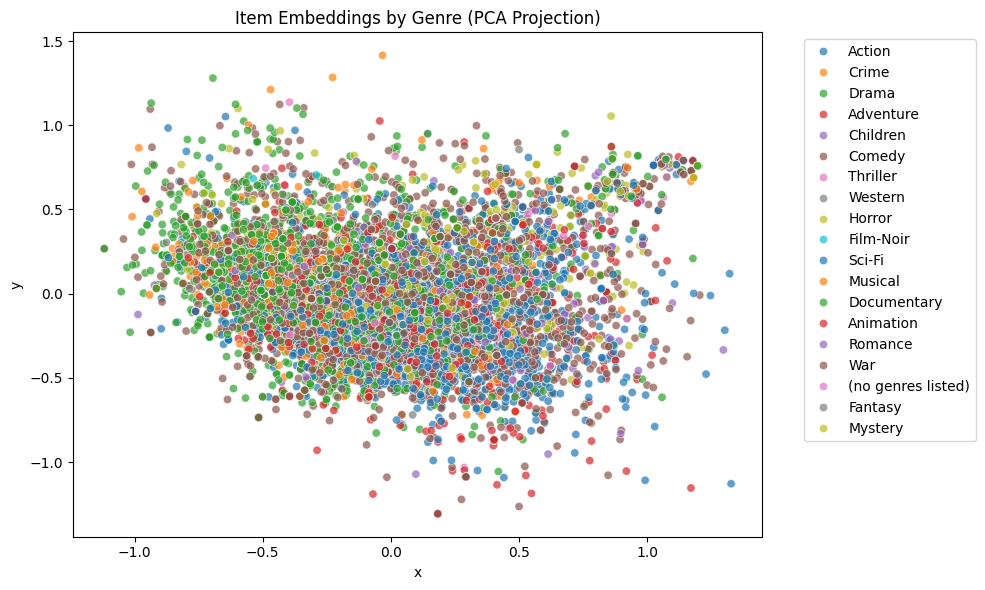

In [192]:
from sklearn.decomposition import PCA

movies_gf=movies_ks.copy(deep=True)

movies_gf['main_genre'] = movies_gf['genres'].str.split('|').str[0]
movies_gf.rename(columns={'movieId': 'id'}, inplace=True)
movies_gf=movies_gf[['id', 'main_genre']]
movies_gf.loc[:, 'id'] = movies_gf['id'].astype(int)

merged = itemFactors.merge(movies_gf[['id', 'main_genre']], on=['id'],how='left')

features = pd.DataFrame(merged['features'].tolist())
pca = PCA(n_components=2)
proj = pca.fit_transform(features)

merged['x'] = proj[:, 0]
merged['y'] = proj[:, 1]


merged_some_genres = merged[merged['main_genre'].isin(['Horror', 'Comedy'])]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='x', y='y', hue='main_genre', palette='tab10', alpha=0.7)
plt.title("Item Embeddings by Genre (PCA Projection)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()